### Setup and Install Dependencies
This cell installs all the necessary libraries required for the project.

In [12]:
# Install necessary libraries
!pip install pandas joblib ipywidgets scikit-learn matplotlib seaborn

### Import Libraries
Import all necessary Python libraries for data manipulation, machine learning, and visualization.

In [13]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import ipywidgets as widgets
from IPython.display import display

### Load Data and Preprocess
Load the dataset, preprocess it, and split it into training and testing sets.

In [14]:
# Load your dataset
df = pd.read_csv('/content/Steel_industry_data.csv')

# Display the first few rows of the dataset
df.head()

# Define features (X) and target variable (y)
X = df.drop(['Usage_kWh', 'date'], axis=1)
y = df['Usage_kWh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Lagging_Current_Reactive_Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']),
        ('cat', OneHotEncoder(), ['WeekStatus', 'Day_of_week', 'Load_Type'])
    ])

# Print the columns of X_train to verify the column names
print(X_train.columns)

Index(['Lagging_Current_Reactive_Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


### Correlation Matrix
Compute and visualize the correlation matrix for features with respect to the target variable.

Correlation with 'Usage_kWh':
                                      Usage_kWh
Usage_kWh                              1.000000
CO2(tCO2)                              0.988180
Lagging_Current_Reactive_Power_kVarh   0.896150
Lagging_Current_Power_Factor           0.385960
Leading_Current_Power_Factor           0.353566
NSM                                    0.234610
Leading_Current_Reactive_Power_kVarh  -0.324922


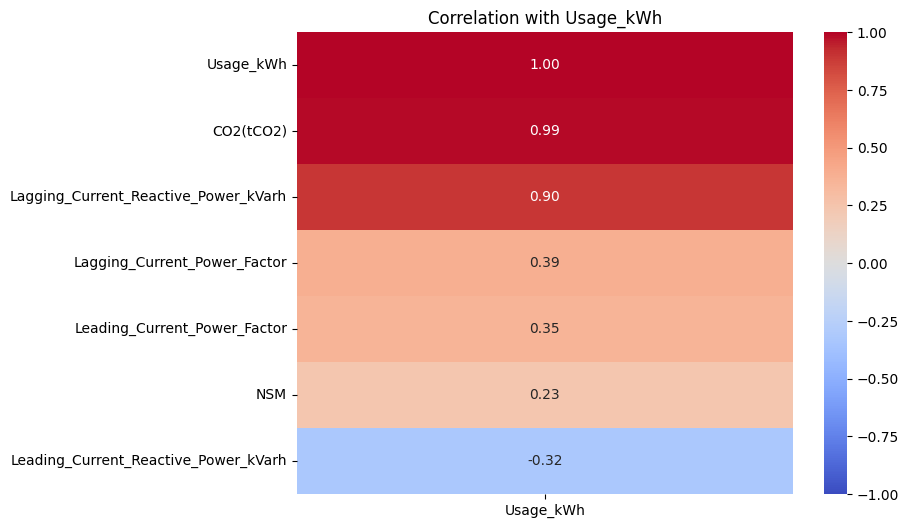

In [15]:
# Compute the correlation matrix for the selected features
correlation_matrix = df[['Lagging_Current_Reactive_Power_kVarh',
                         'Leading_Current_Reactive_Power_kVarh',
                         'CO2(tCO2)',
                         'Lagging_Current_Power_Factor',
                         'Leading_Current_Power_Factor',
                         'NSM',
                         'Usage_kWh']].corr()

# Filter correlations with respect to 'Usage_kWh'
usage_corr = correlation_matrix[['Usage_kWh']].sort_values(by='Usage_kWh', ascending=False)

# Print the filtered correlations
print("Correlation with 'Usage_kWh':")
print(usage_corr)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(usage_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation with Usage_kWh')
plt.show()

### Create and Train the Model
Create a machine learning pipeline, train the model, and evaluate its performance.

In [16]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Save the trained model
joblib.dump(pipeline, 'pipeline.pkl')

# Make predictions and evaluate the model
y_pred = pipeline.predict(X_test)
print("Random Forest - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Random Forest - MAE:", mean_absolute_error(y_test, y_pred))
print("Random Forest - R^2:", r2_score(y_test, y_pred))

Random Forest - RMSE: 0.8508850560698423
Random Forest - MAE: 0.3223913099315064
Random Forest - R^2: 0.9992643702306555


### Graphs for Feature Importance and Predicted vs Actual Consumption
Visualize feature importances and compare predicted versus actual consumption.

                                Feature  Importance
2                             CO2(tCO2)    0.975563
0  Lagging_Current_Reactive_Power_kVarh    0.015525
3          Lagging_Current_Power_Factor    0.005560
4          Leading_Current_Power_Factor    0.001362
5                                   NSM    0.001071


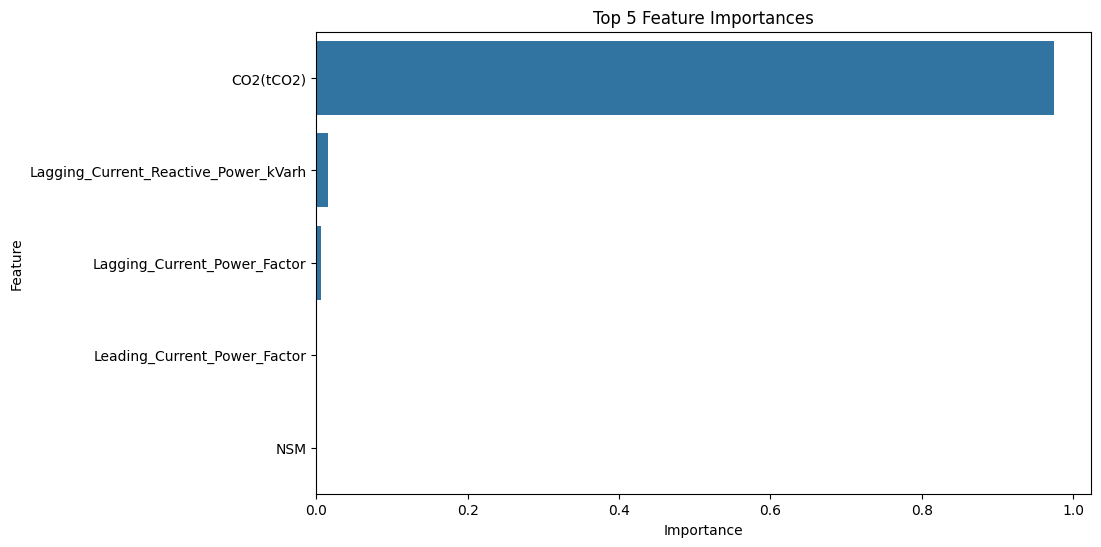

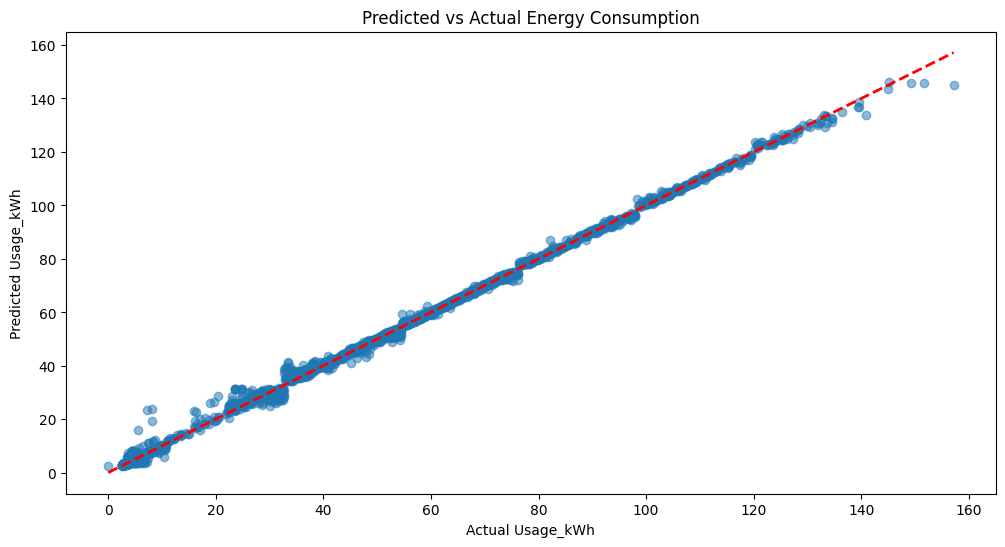

In [17]:
# Extract feature names from numerical transformer
num_feature_names = ['Lagging_Current_Reactive_Power_kVarh',
                     'Leading_Current_Reactive_Power_kVarh',
                     'CO2(tCO2)',
                     'Lagging_Current_Power_Factor',
                     'Leading_Current_Power_Factor',
                     'NSM']

# Extract feature names from categorical transformer
cat_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

# Combine numerical and categorical feature names
feature_names = num_feature_names + list(cat_feature_names)

# Extract feature importances from the trained model
importances = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select the top 5 features
top_5_features = feature_importances.head(5)

# Print top 5 features
print(top_5_features)

# Plot top 5 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_5_features)
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Predicted vs Actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Energy Consumption')
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh')
plt.show()

### Define the Prediction Function
Load the trained model and define a function to make predictions.

In [18]:
# Load the saved pipeline
pipeline = joblib.load('pipeline.pkl')

# Define the prediction function
def predict_energy(lagging_reactive_power, leading_reactive_power, co2, lagging_power_factor, leading_power_factor, nsm, week_status, day_of_week, load_type):
    # Map the load type to match training data
    load_type_map = {
        'Light Load': 'Light_Load',
        'Medium Load': 'Medium_Load',
        'Maximum Load': 'Maximum_Load'
    }
    mapped_load_type = load_type_map[load_type]

    # Create input DataFrame with consistent column names
    input_data = pd.DataFrame({
        'Lagging_Current_Reactive_Power_kVarh': [lagging_reactive_power],
        'Leading_Current_Reactive_Power_kVarh': [leading_reactive_power],
        'CO2(tCO2)': [co2],
        'Lagging_Current_Power_Factor': [lagging_power_factor],
        'Leading_Current_Power_Factor': [leading_power_factor],
        'NSM': [nsm],
        'WeekStatus': [week_status],
        'Day_of_week': [day_of_week],
        'Load_Type': [mapped_load_type]
    })

    # Make prediction
    prediction = pipeline.predict(input_data)
    return prediction[0]

### Create and Display Widgets for User Input
Create widgets to take user input for making predictions.

In [19]:
# Create widgets for user input with adjusted layout
lagging_reactive_power = widgets.FloatText(value=4.5, description='Lagging RP', layout=widgets.Layout(width='200px'))
leading_reactive_power = widgets.FloatText(value=3.5, description='Leading RP', layout=widgets.Layout(width='200px'))
co2 = widgets.FloatText(value=400.0, description='CO2 (tCO2)', layout=widgets.Layout(width='200px'))
lagging_power_factor = widgets.FloatText(value=70.0, description='Lagging PF', layout=widgets.Layout(width='200px'))
leading_power_factor = widgets.FloatText(value=85.0, description='Leading PF', layout=widgets.Layout(width='200px'))
nsm = widgets.IntText(value=3600, description='NSM', layout=widgets.Layout(width='200px'))
week_status = widgets.Dropdown(options=['Weekday', 'Weekend'], value='Weekday', description='Week Status', layout=widgets.Layout(width='200px'))
day_of_week = widgets.Dropdown(options=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], value='Wednesday', description='Day of Week', layout=widgets.Layout(width='200px'))
load_type = widgets.Dropdown(options=['Light Load', 'Medium Load', 'Maximum Load'], value='Maximum Load', description='Load Type', layout=widgets.Layout(width='206px'))

# Display widgets
display(lagging_reactive_power, leading_reactive_power, co2, lagging_power_factor, leading_power_factor, nsm, week_status, day_of_week, load_type)

FloatText(value=4.5, description='Lagging RP', layout=Layout(width='200px'))

FloatText(value=3.5, description='Leading RP', layout=Layout(width='200px'))

FloatText(value=400.0, description='CO2 (tCO2)', layout=Layout(width='200px'))

FloatText(value=70.0, description='Lagging PF', layout=Layout(width='200px'))

FloatText(value=85.0, description='Leading PF', layout=Layout(width='200px'))

IntText(value=3600, description='NSM', layout=Layout(width='200px'))

Dropdown(description='Week Status', layout=Layout(width='200px'), options=('Weekday', 'Weekend'), value='Weekd…

Dropdown(description='Day of Week', index=2, layout=Layout(width='200px'), options=('Monday', 'Tuesday', 'Wedn…

Dropdown(description='Load Type', index=2, layout=Layout(width='206px'), options=('Light Load', 'Medium Load',…

### Create a Button to Perform Prediction
Create a button that triggers the prediction function based on user input.

In [20]:
# Create a button to perform prediction
def on_button_clicked(b):
    try:
        prediction = predict_energy(
            lagging_reactive_power.value,
            leading_reactive_power.value,
            co2.value,
            lagging_power_factor.value,
            leading_power_factor.value,
            nsm.value,
            week_status.value,
            day_of_week.value,
            load_type.value
        )
        print(f"Predicted Energy Consumption: {prediction}")
    except ValueError as e:
        print(f"Error: {e}")

# Define and display the button
button = widgets.Button(
    description="Predict Energy Consumption",
    layout=widgets.Layout(width='400px', height='50px'),  # Adjust the width and height
    style={'font_size': '20px'}  # Increase the font size if needed
)
button.on_click(on_button_clicked)
display(button)

Button(description='Predict Energy Consumption', layout=Layout(height='50px', width='400px'), style=ButtonStyl…

Predicted Energy Consumption: 146.35039999999998
